In [1]:
import pandas as pd
import numpy as np
import tqdm
import os

Get predictions for a subset of data.

```bash
SPLICEVO_DIR=/home/elek/projects/splicevo/
OUT_DIR=/home/elek/projects/splicing/results
CHECKPOINT_DIR=subset
python ${SPLICEVO_DIR}/scripts/splicevo_predict.py \
--checkpoint ${OUT_DIR}/models/${CHECKPOINT_DIR}/best_model.pt \
--test-data ${OUT_DIR}/data_processing/processed_data_test.npz \
--normalization-stats ${OUT_DIR}/models/${CHECKPOINT_DIR}/normalization_stats.json \
--output ${OUT_DIR}/predictions/test_predictions_subset.npz > ${OUT_DIR}/predictions/test_predictions_subset.log 2>&1 &
```

Load subset test data for which predictions were made.

In [ ]:
# Load test data
test_path = "/home/elek/projects/splicing/results/data_processing_filtered/processed_data_test.npz"
data = np.load(test_path)

test_sequences = data['sequences']
test_labels = data['labels']

test_sse = data['usage_sse']
test_alpha = data['usage_alpha']
test_beta = data['usage_beta']

test_sse = np.nan_to_num(test_sse, nan=0.0)
test_alpha = np.nan_to_num(test_alpha, nan=0.0)
test_beta = np.nan_to_num(test_beta, nan=0.0)

print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Test usage shape: {test_sse.shape}")
print(f"Test alpha shape: {test_alpha.shape}")
print(f"Test beta shape: {test_beta.shape}")

Check where are the splice sites in the first few sequences

In [ ]:
# Splice sites in the first few test sequences
for i in range(5):
    print(f"Splice sites in sequence {i}:")
    print(f"  donors (1)    {np.where(test_labels[i] == 1)[0].tolist()}")
    print(f"  acceptors (2) {np.where(test_labels[i] == 2)[0].tolist()}")

Count how many splice sites per test sequence are there.

In [ ]:
num_splice_sites = {}
for i in range(test_labels.shape[0]):
    num_donors = apply(lambda x: np.sum(x == 1), axis=1)(test_labels[i])
    num_acceptors = apply(lambda x: np.sum(x == 2), axis=1)(test_labels[i])
    num_splice_sites['donors'].append(num_donors)
    num_splice_sites['acceptors'].append(num_acceptors)

num_splice_sites

Inspect distribution of usage values at splice sites

In [5]:
cls_dict = {0: 'non-splice site', 1: 'donor', 2: 'acceptor'}

for cls in [1, 2]: # 1: donor, 2: acceptor
    cls_idxs_0 = np.where(test_labels == cls)[0]
    cls_idxs_1 = np.where(test_labels == cls)[1]
    print(f"Number of {cls_dict[cls]} sites: {len(cls_idxs_0)}")
    for tis_idx in range(5): # 5 tissues
        sse_values = test_sse[cls_idxs_0, cls_idxs_1, tis_idx]
        alpha_values = test_alpha[cls_idxs_0, cls_idxs_1, tis_idx]
        beta_values = test_beta[cls_idxs_0, cls_idxs_1, tis_idx]
        print(f"{tis_idx}")
        print(f"{np.sum(sse_values > 0)} sites have mapped usage values ({np.sum(sse_values > 0) / len(sse_values) * 100:.2f}%)")
        print(f"    SSE - mean: {np.mean(sse_values):.4f}, std: {np.std(sse_values):.4f}")
        print(f"    Alpha - mean: {np.mean(alpha_values):.4f}, std: {np.std(alpha_values):.4f}")
        print(f"    Beta - mean: {np.mean(beta_values):.4f}, std: {np.std(beta_values):.4f}")

Number of donor sites: 82795
0
35828 sites have mapped usage values (43.27%)
    SSE - mean: 0.3838, std: 0.4517
    Alpha - mean: 24.8730, std: 116.9533
    Beta - mean: 2.6549, std: 15.7584
1
35793 sites have mapped usage values (43.23%)
    SSE - mean: 0.3742, std: 0.4470
    Alpha - mean: 36.5627, std: 185.6205
    Beta - mean: 5.3453, std: 40.2145
2
30918 sites have mapped usage values (37.34%)
    SSE - mean: 0.3348, std: 0.4438
    Alpha - mean: 15.8029, std: 81.0770
    Beta - mean: 1.8052, std: 14.5304
3
30550 sites have mapped usage values (36.90%)
    SSE - mean: 0.3380, std: 0.4508
    Alpha - mean: 19.3287, std: 86.4877
    Beta - mean: 1.6414, std: 12.5872
4
33901 sites have mapped usage values (40.95%)
    SSE - mean: 0.3631, std: 0.4514
    Alpha - mean: 33.1092, std: 158.8725
    Beta - mean: 3.8974, std: 33.6795
Number of acceptor sites: 79180
0
35859 sites have mapped usage values (45.29%)
    SSE - mean: 0.3964, std: 0.4500
    Alpha - mean: 25.4690, std: 117.5625
 

Load predictions (this takes ~10 mins...)

In [2]:
# Load the model predictions from a file
pred_path = "/home/elek/projects/splicing/results/predictions/test_predictions.npz"
pred = np.load(pred_path)

# Keys in the loaded data
print(f"Available keys: {list(pred.keys())}")
for key in pred.keys():
    print(f"{key}: {pred[key].shape}")

pred_preds = pred['splice_predictions']
pred_probs = pred['splice_probs']

Available keys: ['splice_predictions', 'splice_probs', 'usage_alpha', 'usage_beta', 'usage_sse', 'labels_true', 'usage_alpha_true', 'usage_beta_true', 'usage_sse_true']
splice_predictions: (54043, 1000)
splice_probs: (54043, 1000, 3)
usage_alpha: (54043, 1000, 7)
usage_beta: (54043, 1000, 7)
usage_sse: (54043, 1000, 7)
labels_true: (54043, 1000)
usage_alpha_true: (54043, 1000, 7)
usage_beta_true: (54043, 1000, 7)
usage_sse_true: (54043, 1000, 7)


Inspect predictions vs true labels for the first few sequences.

In [ ]:
# Splice sites in the first few test sequences
for i in range(4):
    print(f"\n(1) Donor splice sites in sequence {i}:")
    print(f"  actual       {np.where(test_labels[i] == 1)[0].tolist()}")
    print(f"  predicted    {np.where(pred_preds[i] == 1)[0].tolist()}")
    print(f"(2) Acceptor splice sites in sequence {i}:")
    print(f"  actual    {np.where(test_labels[i] == 2)[0].tolist()}")
    print(f"  predicted {np.where(pred_preds[i] == 2)[0].tolist()}")  

In [6]:
for i, j in [(0, 0), (0, 1), (1, 21), (2, 13)]:
    print(f"Sequence {i}, position {j}:\n  true label: {test_labels[i,j]}\n  pred label: {pred_preds[i,j]}\n  porbs:{pred_probs[i,j,]}")

Sequence 0, position 0:
  true label: 1
  pred label: 0
  porbs:[0.4989597  0.23828614 0.2627541 ]
Sequence 0, position 1:
  true label: 0
  pred label: 1
  porbs:[0.33909017 0.5215835  0.1393263 ]
Sequence 1, position 21:
  true label: 0
  pred label: 1
  porbs:[0.18840827 0.5999837  0.21160805]
Sequence 2, position 13:
  true label: 1
  pred label: 0
  porbs:[0.4639237  0.37501976 0.1610565 ]


Calculate PR-AUC, the area under the precision-recall curve.

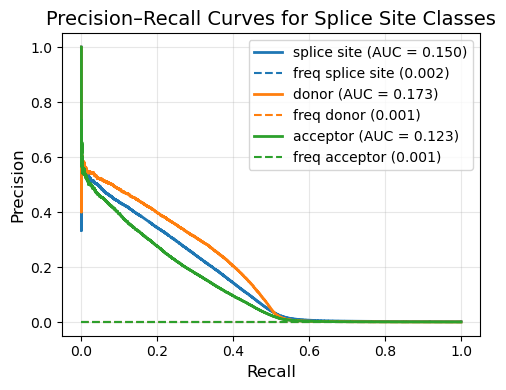

PR-AUC for splice site: 0.1496
PR-AUC for donor: 0.1733
PR-AUC for acceptor: 0.1235


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

pr_auc_scores = {}
plt.figure(figsize=(5, 4))

class_labels = {0: 'splice site', 1: 'donor', 2: 'acceptor'}
class_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}

total_positions = pred['labels_true'].shape[0] * pred['labels_true'].shape[1]

for class_idx in range(3):
    color = class_colors[class_idx]
    label = class_labels[class_idx]
    if class_idx == 0:
        y_true = (pred['labels_true'] != class_idx).astype(int).reshape(-1)
        y_scores = 1 - pred['splice_probs'][:, :, class_idx].reshape(-1)
        freq = np.sum(pred['labels_true'] != class_idx) / total_positions
    else:
        y_true = (pred['labels_true'] == class_idx).astype(int).reshape(-1)
        y_scores = pred['splice_probs'][:, :, class_idx].reshape(-1)
        freq = np.sum(pred['labels_true'] == class_idx) / total_positions

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    pr_auc_scores[class_idx] = pr_auc

    plt.plot(
        recall, precision,
        label=f"{label} (AUC = {pr_auc:.3f})",
        linewidth=2,
        color=color
    )
    plt.hlines(
        y=freq, xmin=0, xmax=1,
        colors=color, linestyles='dashed',
        label=f'freq {label} ({freq:.3f})'
    )

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curves for Splice Site Classes", fontsize=14)
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("plots/pr_curves_splicevo.pdf", dpi=300)
plt.show()

for c, auc_score in pr_auc_scores.items():
    print(f"PR-AUC for {class_labels[c]}: {auc_score:.4f}")


Calculate top-k accuracy by choosing a threshold to make predicted positive sites and actual positive sites have the same number, then computing the fraction of correctly predicted splice sites.

In [6]:
def top_k_accuracy(y_true, y_scores):
    # How many actual positive sites (k) are there?
    k = np.sum(y_true)
    # Select prediction value threshold at which there are k predicted positive sites
    threshold = np.sort(y_scores)[-k]
    # Predicted positive sites
    y_pred = (y_scores >= threshold).astype(int)
    # Calculate accuracy
    accuracy = np.sum((y_pred == 1) & (y_true == 1)) / k
    return accuracy

top_k_acc = {}
for class_idx in range(3):
    if class_idx == 0:
        y_true = (pred['labels_true'] != class_idx).astype(int)
        y_scores = 1 - pred['splice_probs'][:, :, class_idx].reshape(-1)
    else:
        y_true = (pred['labels_true'] == class_idx).astype(int)
        y_scores = pred['splice_probs'][:,:,class_idx]
    y_true = y_true.reshape(-1)
    y_scores = y_scores.reshape(-1)
    acc = top_k_accuracy(y_true, y_scores)
    top_k_acc[class_idx] = acc
    print(f"Top-k accuracy for class {class_idx}: {acc:.4f}")

Top-k accuracy for class 0: 0.2726
Top-k accuracy for class 1: 0.3048
Top-k accuracy for class 2: 0.2362


Splice usage prediction performance on the subset test data.

['splice_predictions', 'splice_probs', 'usage_alpha', 'usage_beta', 'usage_sse', 'labels_true', 'usage_alpha_true', 'usage_beta_true', 'usage_sse_true']

In [7]:
# dictionary of tissues
usage_dict = {}
for tissue in ["Brain", "Cerebellum", "Heart", "Kidney", "Liver", "Ovary", "Testis"]:
    for timepoint_int in range(1, 16):
        timepoint = str(timepoint_int)
        id = f"Human.{tissue}.{timepoint}"
        usage_file=f"/home/elek/projects/splicing/results/spliser/Homo_sapiens/{id}.combined.tsv"
        # Check if the file exists
        if os.path.exists(usage_file):
            i += 1
            usage_dict[i] = id

usage_dict

{1: 'Human.Brain.1',
 2: 'Human.Brain.4',
 3: 'Human.Brain.5',
 4: 'Human.Brain.7',
 5: 'Human.Brain.9',
 6: 'Human.Brain.10',
 7: 'Human.Brain.14',
 8: 'Human.Cerebellum.2',
 9: 'Human.Cerebellum.5',
 10: 'Human.Cerebellum.8',
 11: 'Human.Cerebellum.9',
 12: 'Human.Cerebellum.15',
 13: 'Human.Heart.1',
 14: 'Human.Heart.3',
 15: 'Human.Heart.5',
 16: 'Human.Heart.7',
 17: 'Human.Heart.8',
 18: 'Human.Heart.9',
 19: 'Human.Heart.10',
 20: 'Human.Heart.12',
 21: 'Human.Kidney.2',
 22: 'Human.Kidney.4',
 23: 'Human.Kidney.5',
 24: 'Human.Kidney.6',
 25: 'Human.Kidney.8',
 26: 'Human.Kidney.9',
 27: 'Human.Kidney.10',
 28: 'Human.Kidney.11',
 29: 'Human.Liver.1',
 30: 'Human.Liver.2',
 31: 'Human.Liver.3',
 32: 'Human.Liver.4',
 33: 'Human.Liver.5',
 34: 'Human.Liver.7',
 35: 'Human.Liver.8',
 36: 'Human.Liver.9',
 37: 'Human.Liver.10',
 38: 'Human.Liver.11',
 39: 'Human.Liver.12',
 40: 'Human.Liver.14',
 41: 'Human.Liver.15',
 42: 'Human.Ovary.1',
 43: 'Human.Ovary.2',
 44: 'Human.Ovary.

In [8]:
pred_sse = pred['usage_sse']
true_sse = pred['usage_sse_true']

Select indices that are not NaN in `true_sse` and only use those for further analysis.

In [14]:
for i, id in list(usage_dict.items())[:7]:
    print(f"{i} ID: {id}, MSE: {mse_dict[id]}")

1 ID: Human.Brain.1, MSE: 0.250071257352829
2 ID: Human.Brain.4, MSE: 0.23620560765266418
3 ID: Human.Brain.5, MSE: 0.25925537943840027
4 ID: Human.Brain.7, MSE: 0.2914429008960724
5 ID: Human.Brain.9, MSE: 0.24988816678524017
6 ID: Human.Brain.10, MSE: 0.24350130558013916
7 ID: Human.Brain.14, MSE: 0.23473137617111206


In [15]:
# Calculate the mean squared error for each tissue and timepoint
from sklearn.metrics import mean_squared_error
mse_dict = {}
for i, id in list(usage_dict.items())[:7]:
    true_sse_ = true_sse[:, :, i-1]
    pred_sse_ = pred_sse[:, :, i-1]
    # Flatten arrays and select non-NaN values
    mask = ~np.isnan(true_sse_)
    true_sse_vals = true_sse_[mask]
    pred_sse_vals = pred_sse_[mask]
    mse = mean_squared_error(true_sse_vals, pred_sse_vals)
    mse_dict[id] = mse

In [16]:
# Make a dataframe: species, tissue, timepoint, mse
mse_df = pd.DataFrame(list(mse_dict.items()), columns=['Sample', 'MSE'])
mse_df[['Species', 'Tissue', 'Timepoint']] = mse_df['Sample'].str.split('.', expand=True)

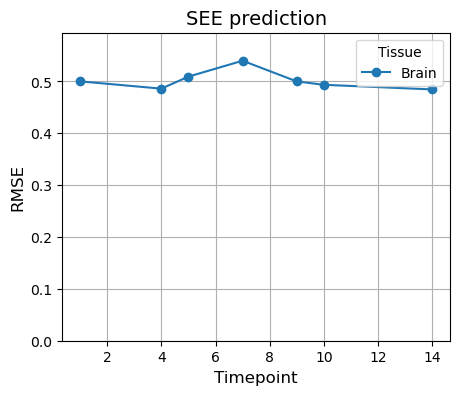

In [23]:
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
for tissue in mse_df['Tissue'].unique():
    tissue_data = mse_df[mse_df['Tissue'] == tissue]
    plt.plot(
        tissue_data['Timepoint'].astype(int),
        np.sqrt(tissue_data['MSE']),
        marker='o',
        label=tissue
    )
plt.title('SEE prediction', fontsize=14)
plt.xlabel('Timepoint', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.ylim(0, np.sqrt(mse_df['MSE']).max() * 1.1)
plt.legend(title='Tissue')
plt.grid()
plt.show()


Select interesting example to show

In [19]:
# For every sequence, identify positions that are not NaN in all tissues, then compare values
num_sequences = true_sse.shape[0]
num_positions = true_sse.shape[1]
num_tissues = true_sse.shape[2]

matched_positions = {}

for seq_idx in range(num_sequences):
    # Find positions where all tissues are not NaN for this sequence
    valid_positions = np.where(np.all(~np.isnan(true_sse[seq_idx, :, :]), axis=1))[0]
    if len(valid_positions) == 0:
        continue
    for pos in valid_positions:
        true_vals = true_sse[seq_idx, pos, :]
        pred_vals = pred_sse[seq_idx, pos, :]
        matched_positions[(seq_idx, pos)] = { "true": true_vals, "pred": pred_vals }

# Combine all matched positions into a single dataframe for plotting
import pandas as pd
all_data = []
for (seq_idx, pos), vals in matched_positions.items():
    for tissue_idx in range(num_tissues):
        all_data.append({
            'sequence': seq_idx,
            'position': pos,
            'group': tissue_idx,
            'true_SSE': vals['true'][tissue_idx],
            'pred_SSE': vals['pred'][tissue_idx]
        })  

all_data_df = pd.DataFrame(all_data)
all_data_df['group'] = all_data_df['group'] + 1
all_data_df['group'] = all_data_df['group'].map(usage_dict)
all_data_df.to_csv("../results/predictions/splicevo_matched_sse_predictions.csv", index=False)
all_data_df

,sequence,position,group,true_SSE,pred_SSE
0,7,574,Human.Brain.1,0.786,0.476481
1,7,574,Human.Brain.4,0.381,0.329092
2,7,574,Human.Brain.5,0.636,0.438877
3,7,574,Human.Brain.7,0.000,0.280274
4,7,574,Human.Brain.9,0.000,0.535877
...,...,...,...,...,...
377176,54039,607,Human.Brain.5,0.841,0.160778
377177,54039,607,Human.Brain.7,0.952,0.442612
377178,54039,607,Human.Brain.9,0.922,0.333819
377179,54039,607,Human.Brain.10,0.975,0.352610


In [55]:
# Group by sequence anposition, and calculate correlation between true and predicted SSE values
correlation_results = []
for (seq_idx, pos), group in all_data_df.groupby(['sequence', 'position']):
    true_vals = group['true_SSE'].values
    pred_vals = group['pred_SSE'].values
    if len(true_vals) < 2:
        continue
    correlation = np.corrcoef(true_vals, pred_vals)[0, 1]
    correlation_results.append({
        'sequence': seq_idx,
        'position': pos,
        'correlation': correlation
    })

correlation_df = pd.DataFrame(correlation_results)
correlation_df.sort_values(by='correlation', ascending=False)

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,sequence,position,correlation
17739,17434,105,0.995031
27491,26427,855,0.991892
32230,30995,251,0.982801
29074,27759,926,0.982681
50901,51262,437,0.982292
...,...,...,...
53367,53567,566,NaN
53551,53748,632,NaN
53609,53792,834,NaN
53738,53938,842,NaN


In [58]:
# For top correlated example, plot true vs predicted SSE values (two plots side by side) across tissues (line colors) and timepoints (x axis)
import matplotlib.pyplot as plt
top_examples = correlation_df.sort_values(by='correlation', ascending=False).iloc[50745:50756]
top_examples

plot_df = all_data_df[(all_data_df['sequence'].isin(top_examples['sequence'])) & (all_data_df['position'].isin(top_examples['position']))]
plot_df['site'] = plot_df['sequence'].astype(str) + '_' + plot_df['position'].astype(str)
plot_df['tissue'] = plot_df['group'].apply(lambda x: x.split('.')[1])
plot_df['timepoint'] = plot_df['group'].apply(lambda x: x.split('.')[2])
plot_df

/tmp/ipykernel_3066256/179616838.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['site'] = plot_df['sequence'].astype(str) + '_' + plot_df['position'].astype(str)
/tmp/ipykernel_3066256/179616838.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['tissue'] = plot_df['group'].apply(lambda x: x.split('.')[1])
/tmp/ipykernel_3066256/179616838.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,sequence,position,group,true_SSE,pred_SSE,site,tissue,timepoint
37639,5015,0,Human.Brain.1,0.000,0.431497,5015_0,Brain,1
37640,5015,0,Human.Brain.4,0.588,0.291615,5015_0,Brain,4
37641,5015,0,Human.Brain.5,0.000,0.278928,5015_0,Brain,5
37642,5015,0,Human.Brain.7,0.625,0.209100,5015_0,Brain,7
37643,5015,0,Human.Brain.9,0.000,0.391446,5015_0,Brain,9
...,...,...,...,...,...,...,...,...
340916,49097,878,Human.Brain.5,0.968,0.373684,49097_878,Brain,5
340917,49097,878,Human.Brain.7,1.000,0.241505,49097_878,Brain,7
340918,49097,878,Human.Brain.9,0.982,0.391084,49097_878,Brain,9
340919,49097,878,Human.Brain.10,0.958,0.322675,49097_878,Brain,10


/tmp/ipykernel_3066256/377170670.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)


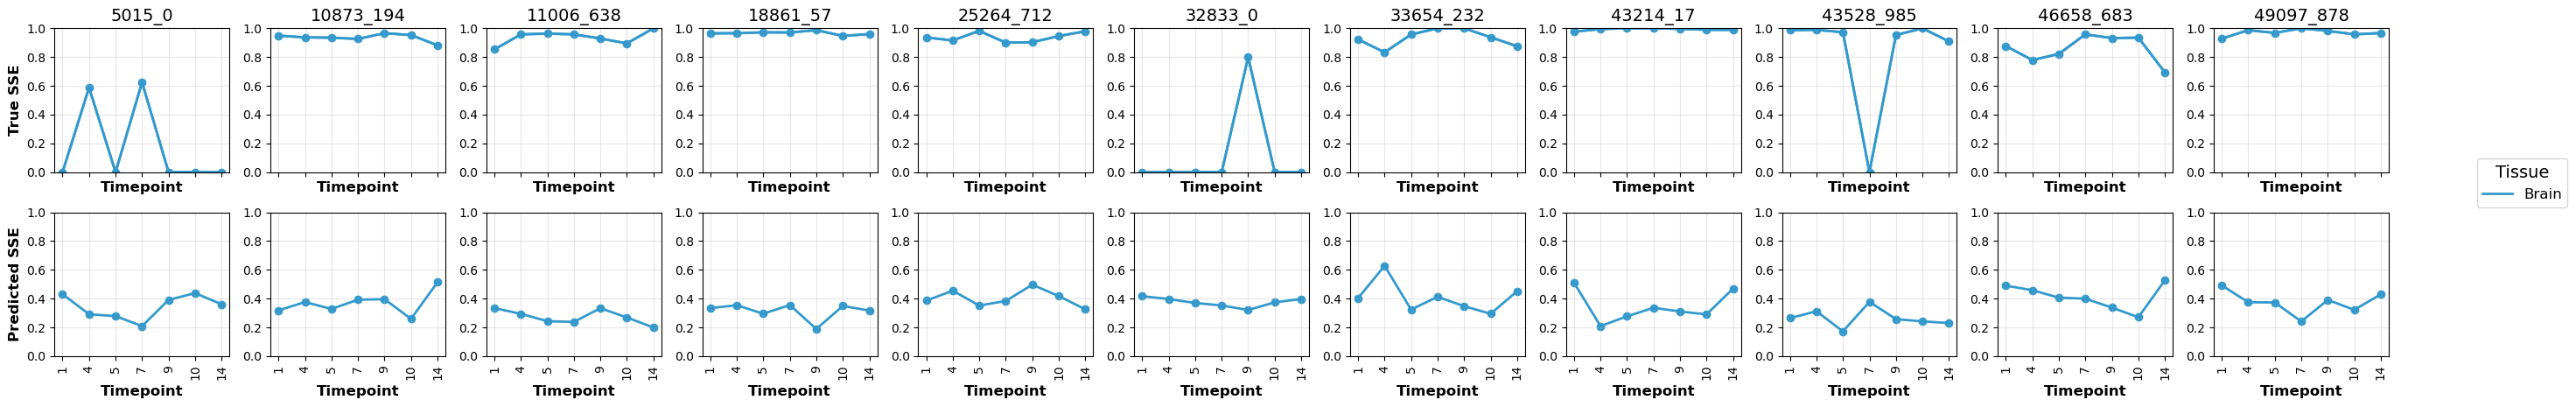

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import make_interp_spline

# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

# Get unique sites
unique_sites = plot_df['site'].unique()

# Smooth values?
smooth = False

# Convert timepoint to integer then categorical with proper order
timepoint_order = sorted(plot_df['timepoint'].unique(), key=lambda x: int(''.join(filter(str.isdigit, x))))
plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)

# Remove Ovary 
# plot_df = plot_df[plot_df['tissue'] != 'Ovary']

# Create a grid of plots: 2 rows (sse true and predicted), n columns (n = number of sites)
n_sites = len(unique_sites)
fig, axes = plt.subplots(2, n_sites, figsize=(2.5 * n_sites, 5), sharex='col')

if n_sites == 1:
    axes = axes.reshape(2, 1)  # Ensure axes is always 2D

legend_handles, legend_labels = [], []

for col_idx, site in enumerate(unique_sites):
    site_data = plot_df[plot_df['site'] == site]
    handles, labels = [], []

    for tissue in site_data['tissue'].unique():
        tissue_data = site_data[site_data['tissue'] == tissue].sort_values('timepoint')
        color = tissue_colors.get(tissue, '#000000')
        x_values = tissue_data['timepoint'].cat.codes
        y_sse_true = tissue_data['true_SSE'].values
        y_sse_pred = tissue_data['pred_SSE'].values


        # Spline smoothing
        def smooth_spline(x, y):
            if smooth and len(x) > 3:
                x_dense = np.linspace(x.min(), x.max(), 100)
                if len(np.unique(x)) < 4:
                    return x, y
                spline = make_interp_spline(x, y, k=2)
                y_smooth = spline(x_dense)
                return x_dense, y_smooth
            else:
                return x, y

        # True SSE
        x_sse, y_sse_true_smooth = smooth_spline(x_values, y_sse_true)
        line_sse, = axes[0, col_idx].plot(x_sse, y_sse_true_smooth, label=tissue, color=color, linewidth=2)
        axes[0, col_idx].plot(x_sse, y_sse_true_smooth, color=color, linewidth=2)
        axes[0, col_idx].scatter(x_values, y_sse_true, color=color, marker='o', s=36)

        # Predicted SSE
        x_sse, y_sse_pred_smooth = smooth_spline(x_values, y_sse_pred)
        axes[1, col_idx].plot(x_sse, y_sse_pred_smooth, color=color, linewidth=2)
        axes[1, col_idx].scatter(x_values, y_sse_pred, color=color, marker='o', s=36)

        if col_idx == 0:
            legend_labels.append(tissue)
            legend_handles.append(line_sse)
    
    # True SSE plot
    axes[0, col_idx].set_ylim(0, 1)
    axes[0, col_idx].set_title(f'{site}', fontsize=14)
    axes[0, col_idx].set_xlabel('Timepoint', fontsize=12, fontweight='bold')
    axes[0, col_idx].set_xticks(range(len(timepoint_order)))
    axes[0, col_idx].set_xticklabels(timepoint_order, rotation=90)
    axes[0, col_idx].grid(True, alpha=0.3)

    # Predicted SSE plot
    axes[1, col_idx].set_ylim(0, 1)
    axes[1, col_idx].set_xlabel('Timepoint', fontsize=12, fontweight='bold')
    axes[1, col_idx].set_xticks(range(len(timepoint_order)))
    axes[1, col_idx].set_xticklabels(timepoint_order, rotation=90)
    axes[1, col_idx].grid(True, alpha=0.3)

axes[0, 0].set_ylabel('True SSE', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Predicted SSE', fontsize=12, fontweight='bold')

# Legend
fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(1.05, 0.5),
           title='Tissue', title_fontsize=14, fontsize=12, ncol=1)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for legend

# Save figure to pdf
plt.savefig('plots/SSE_prediction_example.pdf', bbox_inches='tight')

plt.show()

/tmp/ipykernel_3066256/1297415608.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)


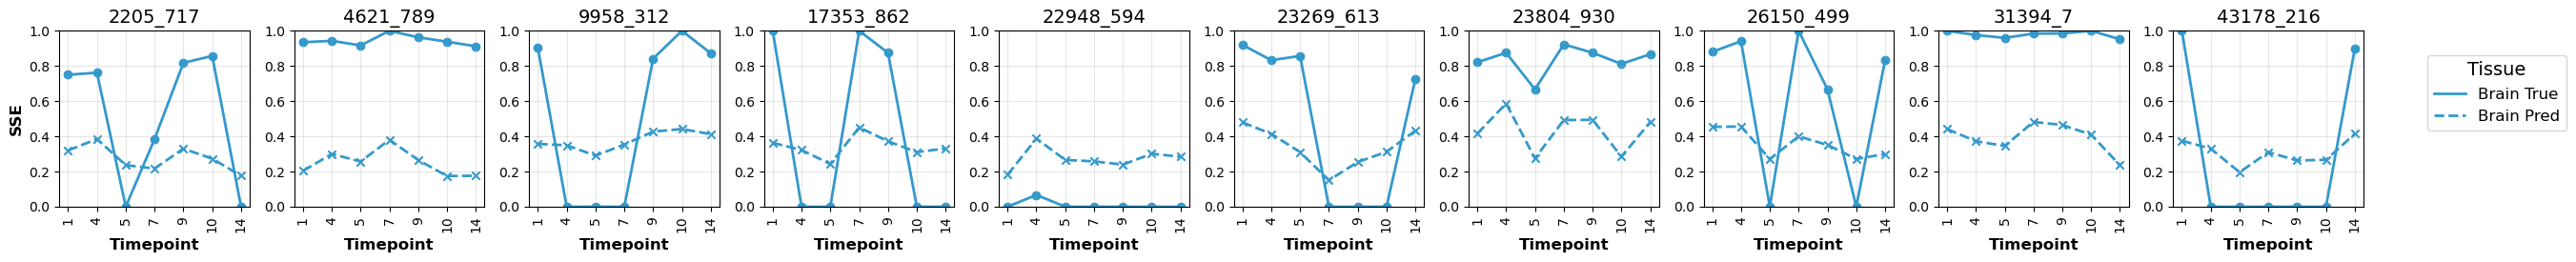

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline

# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

unique_sites = plot_df['site'].unique()
smooth = False

timepoint_order = sorted(plot_df['timepoint'].unique(), key=lambda x: int(''.join(filter(str.isdigit, x))))
plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)

n_sites = len(unique_sites)
fig, axes = plt.subplots(1, n_sites, figsize=(2.5 * n_sites, 3), sharex='col')

if n_sites == 1:
    axes = axes.reshape(1, 1)

legend_handles, legend_labels = [], []

for col_idx, site in enumerate(unique_sites):
    site_data = plot_df[plot_df['site'] == site]
    for tissue in site_data['tissue'].unique():
        tissue_data = site_data[site_data['tissue'] == tissue].sort_values('timepoint')
        color = tissue_colors.get(tissue, '#000000')
        x_values = tissue_data['timepoint'].cat.codes
        y_sse_true = tissue_data['true_SSE'].values
        y_sse_pred = tissue_data['pred_SSE'].values

        def smooth_spline(x, y):
            if smooth and len(x) > 3:
                x_dense = np.linspace(x.min(), x.max(), 100)
                if len(np.unique(x)) < 4:
                    return x, y
                spline = make_interp_spline(x, y, k=2)
                y_smooth = spline(x_dense)
                return x_dense, y_smooth
            else:
                return x, y

        # True SSE: solid line
        x_sse, y_sse_true_smooth = smooth_spline(x_values, y_sse_true)
        line_true, = axes[col_idx].plot(x_sse, y_sse_true_smooth, label=f'{tissue} True', color=color, linewidth=2, linestyle='-')
        axes[col_idx].scatter(x_values, y_sse_true, color=color, marker='o', s=36)

        # Predicted SSE: dashed line
        x_sse, y_sse_pred_smooth = smooth_spline(x_values, y_sse_pred)
        line_pred, = axes[col_idx].plot(x_sse, y_sse_pred_smooth, label=f'{tissue} Pred', color=color, linewidth=2, linestyle='--')
        axes[col_idx].scatter(x_values, y_sse_pred, color=color, marker='x', s=36)

        if col_idx == 0:
            legend_handles.extend([line_true, line_pred])
            legend_labels.extend([f'{tissue} True', f'{tissue} Pred'])

    axes[col_idx].set_ylim(0, 1)
    axes[col_idx].set_title(f'{site}', fontsize=14)
    axes[col_idx].set_xlabel('Timepoint', fontsize=12, fontweight='bold')
    axes[col_idx].set_xticks(range(len(timepoint_order)))
    axes[col_idx].set_xticklabels(timepoint_order, rotation=90)
    axes[col_idx].grid(True, alpha=0.3)

axes[0].set_ylabel('SSE', fontsize=12, fontweight='bold')

fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(1.05, 0.5),
           title='Tissue', title_fontsize=14, fontsize=12, ncol=1)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('plots/SSE_prediction_example.pdf', bbox_inches='tight')
plt.show()


Alternativelly, find an example from paper

In [24]:
metadata = pd.read_csv("/home/elek/projects/splicing/results/data_processing_filtered/metadata_test.csv.gz")
metadata

,genome_id,chromosome,gene_id,strand,window_start,window_end,n_donor_sites,n_acceptor_sites
0,human_GRCh37,1,hum.10,+,1747302,1748302,1,0
1,human_GRCh37,1,hum.10,+,1748302,1749302,0,1
2,human_GRCh37,1,hum.10,+,1749302,1750302,1,0
3,human_GRCh37,1,hum.1000,-,32302014,32303014,0,1
4,human_GRCh37,1,hum.1000,-,32329014,32330014,1,1
...,...,...,...,...,...,...,...,...
79151,human_GRCh37,1,hum.984,+,29441723,29442723,68,68
79152,human_GRCh37,1,hum.984,+,29442723,29443723,0,67
79153,human_GRCh37,1,hum.984,+,29443723,29444723,2,1
79154,human_GRCh37,1,hum.984,+,29444723,29445723,2,7


In [25]:
chr = 1
start = 110167924
end = 110168058

metadata_subset = metadata[
    (metadata['chromosome'] == chr) &
    (metadata['window_start'] < start) &
    (metadata['window_end'] > start)
]
print(metadata_subset)

idx = metadata_subset.index.tolist()



         genome_id  chromosome   gene_id strand  window_start  window_end  \
9091  human_GRCh37           1  hum.3042      +     110167901   110168901   

      n_donor_sites  n_acceptor_sites  
9091            181               178  


In [29]:
records = []
for i, id in list(usage_dict.items())[:7]:
    # Get true and predicted SSE for this tissue/timepoint
    true_vals = true_sse[idx, :, i-1]
    pred_vals = pred_sse[idx, :, i-1]
    # Mask for non-NaN values
    valid_mask = ~np.isnan(true_vals)
    valid_mask_idx = np.where(valid_mask)[1]
    # Select all non-NaN values
    true_selected = true_vals[valid_mask]
    pred_selected = pred_vals[valid_mask]
    # Add to records
    for j in range(len(true_selected)):
        records.append({
            'Site': valid_mask_idx[j],
            'Sample': id,
            'Tissue': id.split('.')[1],
            'Timepoint': id.split('.')[2],
            'True_SSE': true_selected[j],
            'Pred_SSE': pred_selected[j]
        })

example_df = pd.DataFrame(records)
example_df

,Site,Sample,Tissue,Timepoint,True_SSE,Pred_SSE
0,23,Human.Brain.1,Brain,1,0.591,0.376083
1,155,Human.Brain.1,Brain,1,0.789,0.259321
2,283,Human.Brain.1,Brain,1,0.000,0.318707
3,382,Human.Brain.1,Brain,1,0.739,0.361473
4,514,Human.Brain.1,Brain,1,0.974,0.271783
5,880,Human.Brain.1,Brain,1,0.974,0.468205
6,950,Human.Brain.1,Brain,1,0.903,0.534225
7,23,Human.Brain.4,Brain,4,0.528,0.451342
8,155,Human.Brain.4,Brain,4,0.571,0.498136
9,382,Human.Brain.4,Brain,4,0.778,0.389060


/tmp/ipykernel_3066256/1046142314.py:25: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i, 0].set_ylim(0, site_df['True_SSE'].max() * 1.1)


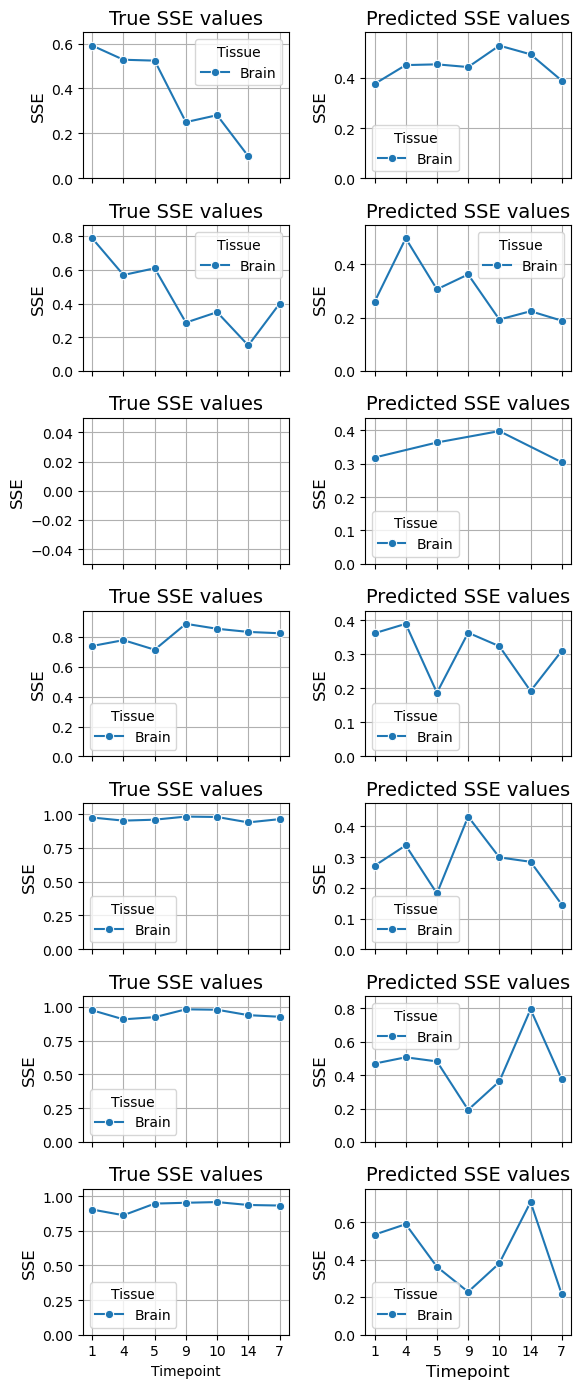

In [34]:
# Plot predicted and true values for each site separately, skipping 0s and negative values
import seaborn as sns
import matplotlib.pyplot as plt

sites = example_df['Site'].unique()
num_sites = len(sites)
fig, axes = plt.subplots(num_sites, 2, figsize=(6, 2 * num_sites), sharex=True)

for i, site in enumerate(sites):
    site_df = example_df[example_df['Site'] == site]
    # Filter out 0s and negative values
    site_df_true = site_df[site_df['True_SSE'] > 0]
    site_df_pred = site_df[site_df['Pred_SSE'] > 0]
    # True SSE
    sns.lineplot(
        data=site_df_true,
        x='Timepoint',
        y='True_SSE',
        hue='Tissue',
        marker='o',
        ax=axes[i, 0]
    )
    axes[i, 0].set_title(f'True SSE values', fontsize=14)
    axes[i, 0].set_ylabel('SSE', fontsize=12)
    axes[i, 0].set_ylim(0, site_df['True_SSE'].max() * 1.1)
    axes[i, 0].grid()
    # Predicted SSE
    sns.lineplot(
        data=site_df_pred,
        x='Timepoint',
        y='Pred_SSE',
        hue='Tissue',
        marker='o',
        ax=axes[i, 1]
    )
    axes[i, 1].set_title(f'Predicted SSE values', fontsize=14)
    axes[i, 1].set_ylabel('SSE', fontsize=12)
    axes[i, 1].set_ylim(0, site_df['Pred_SSE'].max() * 1.1)
    axes[i, 1].grid()

plt.xlabel('Timepoint', fontsize=12)
plt.tight_layout()
plt.show()
